In [2]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
from sklearn.manifold import MDS
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.metrics import euclidean_distances


In [3]:
run 'Step1.ipynb'

In [5]:
run 'Step4.ipynb'

In [ ]:
run 'Step6.ipynb'

# Distance Matrix

In [20]:
def adjacent(file,dir = True):
    nodes,edges = get_data(file)[2],get_data(file)[3]
    adj = {node:[child for child in child_nodes(edges,node)[1]] for node in nodes}

    if dir == False:
        for node in nodes:
            parents = parent_nodes(edges,node)[1]
            for parent in parents:
                adj[node].append(parent)
    return adj

#print(adjacent('Datasets/smallnet.dot'))

def bfs_distance(graph, start):
    visited = set()
    distances = {start: 0}
    queue = [start]

    while queue:
        current_node = queue.pop(0)
        visited.add(current_node)

        for neighbor in graph[current_node]:
            if neighbor not in visited:
                distances[neighbor] = distances[current_node] + 1
                queue.append(neighbor)

    return distances


def compute_distance_matrix(file,dir = True):
    graph = adjacent(file,dir)
    nodes = get_data(file)[2]
    distance_matrix = {node:bfs_distance(graph, node) for node in graph}

    for node1 in distance_matrix:
        left_nodes = set(nodes)-set(distance_matrix[node1].keys())
        for node2 in left_nodes:
            distance_matrix[node1][node2] = -1

    return distance_matrix


distance_matrix = compute_distance_matrix('Datasets/smallnet.dot')
#print(distance_matrix)
for node in distance_matrix:
    print(f"Distances from node {node}: {distance_matrix[node]}")


Distances from node 5: {'5': 0, '13': 1, '3': 2, '15': 3, '7': 4, '18': 5, '8': -1, '21': -1, '14': -1, '9': -1, '19': -1, '4': -1, '10': -1, '16': -1, '17': -1, '12': -1, '22': -1, '23': -1, '24': -1, '6': -1, '1': -1, '2': -1, '20': -1, '11': -1}
Distances from node 13: {'13': 0, '3': 1, '15': 2, '7': 3, '18': 4, '8': -1, '21': -1, '19': -1, '10': -1, '4': -1, '23': -1, '11': -1, '6': -1, '1': -1, '5': -1, '14': -1, '20': -1, '9': -1, '16': -1, '17': -1, '12': -1, '22': -1, '2': -1, '24': -1}
Distances from node 3: {'3': 0, '15': 1, '7': 2, '18': 3, '8': -1, '21': -1, '19': -1, '10': -1, '4': -1, '23': -1, '11': -1, '6': -1, '1': -1, '5': -1, '14': -1, '20': -1, '9': -1, '16': -1, '17': -1, '12': -1, '22': -1, '13': -1, '2': -1, '24': -1}
Distances from node 6: {'6': 0, '14': 1, '21': 2, '19': 3, '11': 3, '20': 4, '8': 4, '9': 4, '12': 5, '1': 5, '23': 6, '3': -1, '5': -1, '15': -1, '4': -1, '10': -1, '16': -1, '17': -1, '22': -1, '7': -1, '13': -1, '2': -1, '18': -1, '24': -1}
Dista

# Metrics TSNE

# T-sne

In [208]:
def plot_tsne(distances, node_list, edge_list, perplexity=10, learning_rate=300, n_iter=750, interactive=False):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='pca')
    embeddings = tsne.fit_transform(distances)

    kl_div = tsne.kl_divergence_
    for i in range(n_iter):
        print(f"Iteration {i+1}: KL divergence = {kl_div}")
        if kl_div < 0.05:
            print(f"t-SNE has converged in iteration n. {i+1}")
            break

    # KMeans clustering
    # kmeans = KMeans(n_clusters=8)  # You can adjust the number of clusters
    # labels = kmeans.fit_predict(embeddings)

    plt.figure(figsize=(10, 8))
    #plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=50)
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                    [embeddings[u_index, 1], embeddings[v_index, 1]], 
                    color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization of Node Similarities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    #plt.colorbar(label='Cluster ID')
    plt.colorbar(label='Similarity')
    plt.show()

# Miserables

In [209]:
nodes,edges,node_list,edge_list,weights = get_data_step6('Datasets/LesMiserables.dot')

In [164]:
def compute_similarity_matrix(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                elif (target, source) in edge_weights:
                    distances[i, j] = edge_weights[(target, source)]
                else:
                    distances[i, j] = np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + distances[i, j])
        similarities[j, i] = similarities[i, j]  # Similarity matrix is symmetric

    np.fill_diagonal(similarities, 1) #diagonal 1

    return similarities

similarity_matrix = compute_similarity_matrix(node_list, edge_list, weights)

#print("Similarity matrix:")
#print("\t" + "\t".join(node_list))
#for i in range(len(node_list)):
#    print(node_list[i], "\t", end="")
#    for j in range(len(node_list)):
#        print("{:.2f}".format(similarity_matrix[i, j]), "\t", end="")
#    print()

similarities = compute_similarity_matrix(node_list, edge_list, weights)


In [210]:
def floyd_warshall(node_list, edge_list, weights):
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)

    np.fill_diagonal(distances, 0)

    for (u, v), weight in weights.items():
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = weight
        distances[j, i] = weight  # If the graph is undirected

    for k in range(num_nodes):
        for i in range(num_nodes):
            for j in range(num_nodes):
                distances[i, j] = min(distances[i, j], distances[i, k] + distances[k, j])

    return distances

distances = floyd_warshall(node_list, edge_list, weights)
print(distances)


[[ 0.  1.  9. ...  9.  9. 11.]
 [ 1.  0.  8. ...  8.  8. 10.]
 [ 9.  8.  0. ...  6.  6.  8.]
 ...
 [ 9.  8.  6. ...  0.  5.  5.]
 [ 9.  8.  6. ...  5.  0.  8.]
 [11. 10.  8. ...  5.  8.  0.]]


Iteration 1: KL divergence = -0.2616579830646515
t-SNE has converged in iteration n. 1


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_41076/1869575682.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


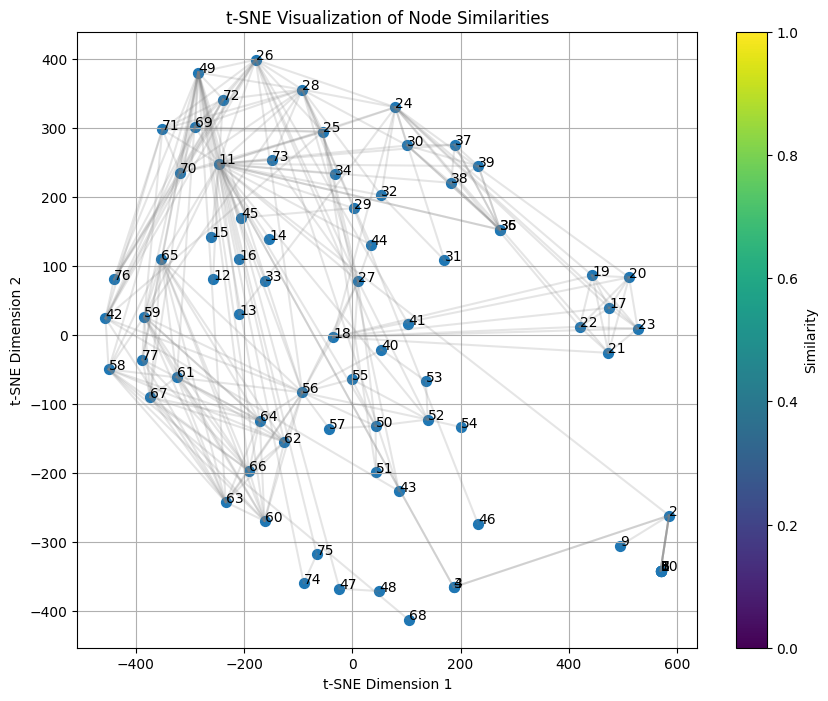

In [222]:
plot_tsne(distances, node_list, edge_list, perplexity=15, learning_rate=300, n_iter=1000, interactive=False)

# Jazz


In [167]:
nodes,edges,node_list,edge_list,weights = get_data_step6('Datasets/JazzNetwork.dot')

#print(nodes) 
#print(edges)
#print(node_list)
#print(edge_list)
#print(weights)

In [168]:
def compute_similarity_matrix(node_list, edge_list): #no wweights
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)
    
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = 1
        distances[j, i] = 1
    
    similarities = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                similarities[i, j] = 1 / (1 + distances[i, j])
    
    np.fill_diagonal(similarities, 1)
    
    return similarities

similarities = compute_similarity_matrix(node_list, edge_list)

#print("Similarity matrix:")
#print("\t" + "\t".join(node_list))
#for i in range(len(node_list)):
#    print(node_list[i], "\t", end="")
#    for j in range(len(node_list)):
#        print("{:.2f}".format(similarities[i, j]), "\t", end="")
#    print()



Iteration 1: KL divergence = 0.38316023349761963
Iteration 2: KL divergence = 0.38316023349761963
Iteration 3: KL divergence = 0.38316023349761963
Iteration 4: KL divergence = 0.38316023349761963
Iteration 5: KL divergence = 0.38316023349761963
Iteration 6: KL divergence = 0.38316023349761963
Iteration 7: KL divergence = 0.38316023349761963
Iteration 8: KL divergence = 0.38316023349761963
Iteration 9: KL divergence = 0.38316023349761963
Iteration 10: KL divergence = 0.38316023349761963
Iteration 11: KL divergence = 0.38316023349761963
Iteration 12: KL divergence = 0.38316023349761963
Iteration 13: KL divergence = 0.38316023349761963
Iteration 14: KL divergence = 0.38316023349761963
Iteration 15: KL divergence = 0.38316023349761963
Iteration 16: KL divergence = 0.38316023349761963
Iteration 17: KL divergence = 0.38316023349761963
Iteration 18: KL divergence = 0.38316023349761963
Iteration 19: KL divergence = 0.38316023349761963
Iteration 20: KL divergence = 0.38316023349761963
Iteration

/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_41076/3389298344.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


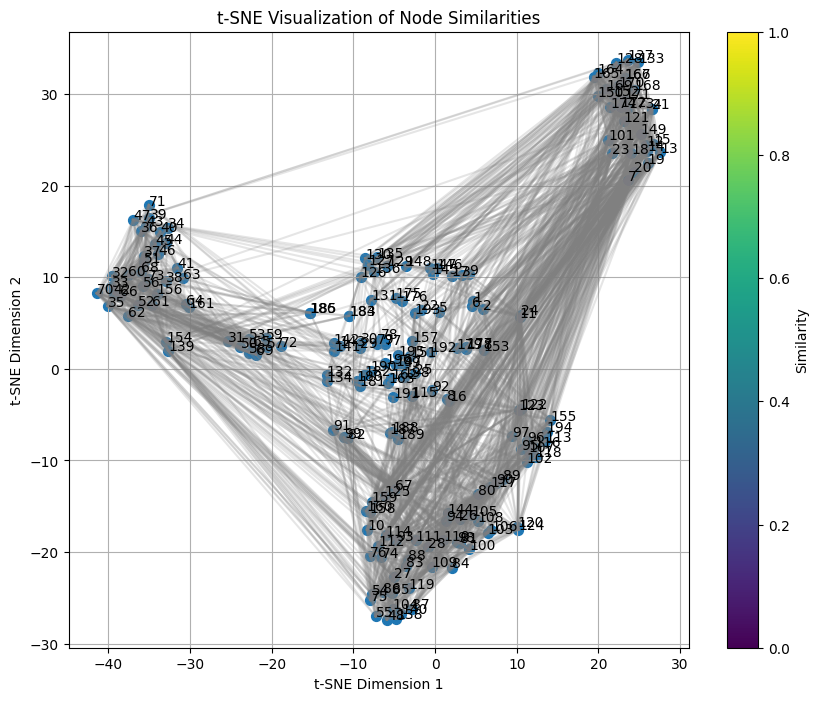

In [169]:
plot_tsne(similarities, node_list, edge_list, perplexity=15, learning_rate=250, n_iter=1500, interactive=False)

# League

In [181]:
nodes,edges,node_list,edge_list,weights = get_data_league('Datasets/LeagueNetwork.dot')

#print(nodes) 
#print(edges)
#print(node_list)
#print(edge_list)
#print(weights)

In [172]:
def compute_similarity_matrix_league(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                else:
                    distances[i, j] = -edge_weights[(target, source)] if (target, source) in edge_weights else np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + abs(distances[i, j])) if distances[i, j] != np.inf else 0 
        similarities[j, i] = similarities[i, j]  

    np.fill_diagonal(similarities, 1)  # Diagonal set to 1

    return similarities

similarities = compute_similarity_matrix_league(node_list, edge_list, weights)

#print("Similarity matrix:")
#print("\t" + "\t".join(node_list))
#for i in range(len(node_list)):
#    print(node_list[i], "\t", end="")
#    for j in range(len(node_list)):
#        print("{:.2f}".format(similarities[i, j]), "\t", end="")
#    print()

Iteration 1: KL divergence = 0.23730000853538513
Iteration 2: KL divergence = 0.23730000853538513
Iteration 3: KL divergence = 0.23730000853538513
Iteration 4: KL divergence = 0.23730000853538513
Iteration 5: KL divergence = 0.23730000853538513
Iteration 6: KL divergence = 0.23730000853538513
Iteration 7: KL divergence = 0.23730000853538513
Iteration 8: KL divergence = 0.23730000853538513
Iteration 9: KL divergence = 0.23730000853538513
Iteration 10: KL divergence = 0.23730000853538513
Iteration 11: KL divergence = 0.23730000853538513
Iteration 12: KL divergence = 0.23730000853538513
Iteration 13: KL divergence = 0.23730000853538513
Iteration 14: KL divergence = 0.23730000853538513
Iteration 15: KL divergence = 0.23730000853538513
Iteration 16: KL divergence = 0.23730000853538513
Iteration 17: KL divergence = 0.23730000853538513
Iteration 18: KL divergence = 0.23730000853538513
Iteration 19: KL divergence = 0.23730000853538513
Iteration 20: KL divergence = 0.23730000853538513
Iteration

/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_41076/3389298344.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


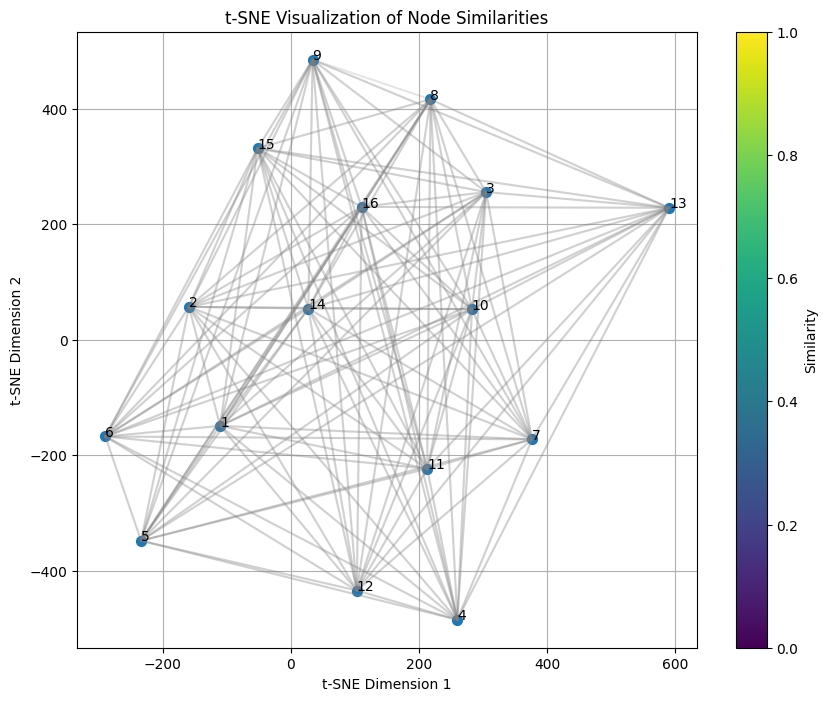

In [173]:
plot_tsne(similarities, node_list, edge_list, perplexity=10, learning_rate=200, n_iter=1000, interactive=False)

# Testing

[[ 0.  1.  9. ...  9.  9. 11.]
 [ 1.  0.  8. ...  8.  8. 10.]
 [ 9.  8.  0. ...  6.  6.  8.]
 ...
 [ 9.  8.  6. ...  0.  5.  5.]
 [ 9.  8.  6. ...  5.  0.  8.]
 [11. 10.  8. ...  5.  8.  0.]]
Continuity 0.4651985695463957
Trustworthiness 0.22051571616789012
Stress 2294729.6712615527


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_41076/377616631.py:145: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)


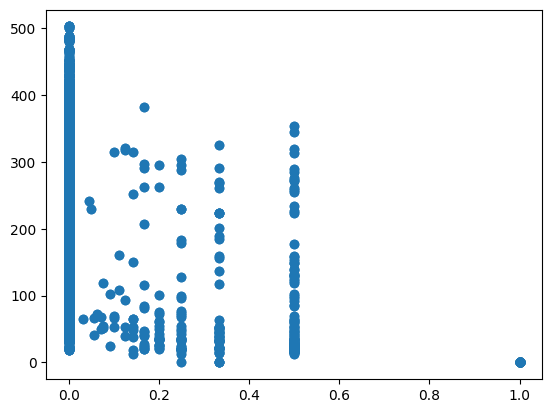

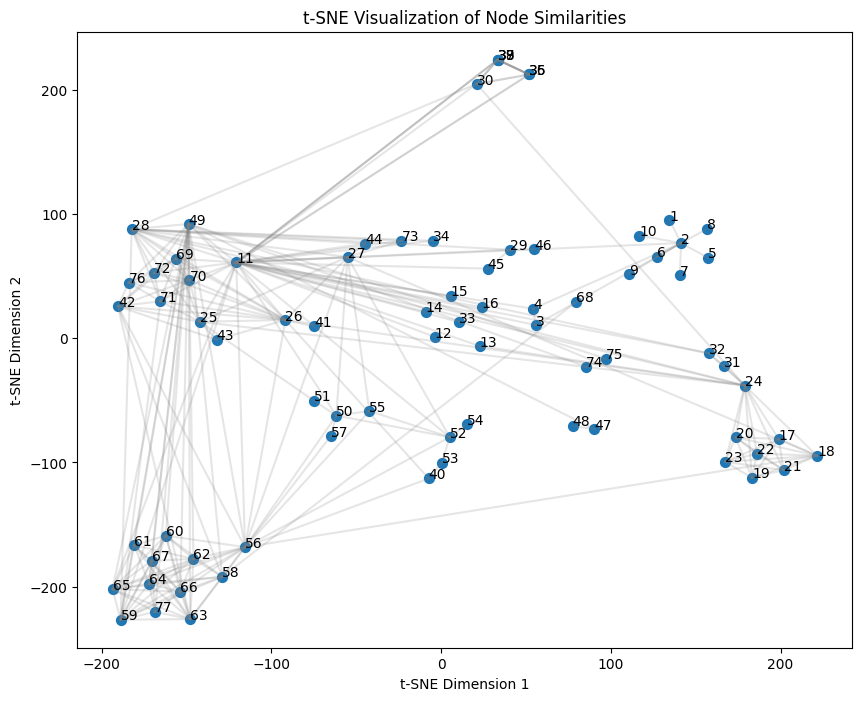

In [224]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def compute_continuity(similarities, distances_Y, k=5):
    """
    Compute continuity metric for t-SNE projection.

    Parameters:
    - similarities: Similarity matrix for the high-dimensional data.
    - distances_Y: Euclidean distances for the t-SNE projected points in 2D space.
    - k: Number of neighbors to consider.

    Returns:
    - Continuity score.
    """
    n = len(similarities)

    nn_orig = similarities.argsort()
    nn_proj = distances_Y.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        V = np.setdiff1d(knn_orig[i], knn_proj[i])

        sum_j = 0
        for j in range(V.shape[0]):
            sum_j += np.where(nn_proj[i] == V[j])[0] - k

        sum_i += sum_j

    return float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)).squeeze())

def compute_trustworthiness(similarities, distances_Y, k=5):
    """
    Compute trustworthiness metric for t-SNE projection.

    Parameters:
    - similarities: Similarity matrix for the high-dimensional data.
    - distances_Y: Euclidean distances for the t-SNE projected points in 2D space.
    - k: Number of neighbors to consider.

    Returns:
    - Trustworthiness score.
    """
    n = len(similarities)

    nn_orig = similarities.argsort()
    nn_proj = distances_Y.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        U = np.setdiff1d(knn_proj[i], knn_orig[i])

        sum_j = 0
        for j in range(U.shape[0]):
            sum_j += np.where(nn_orig[i] == U[j])[0] - k

        sum_i += sum_j

    trustworthiness_score = float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)).squeeze())
    return trustworthiness_score

def compute_stress(similarities, distances_Y):
    
    #print(f"similarities: {similarities}")
    #print(f"distances_Y: {distances_Y}")
    #n = len(similarities)
    
    # Create a mask to ignore the diagonal and only consider the lower triangular part
    #mask = np.tri(n, k=-1)
    stress = np.sum((similarities - distances_Y)**2) / np.sum(similarities**2)
    #stress = np.sum((similarities - distances_Y)**2 * mask) / np.sum(similarities**2 * mask)

    return stress

def compute_shepard(distances_highD, distances_lowD):
    
    shepard_values = []
    plt.scatter(distances_highD, distances_lowD)

    return shepard_values

#def metric_pq_shepard_diagram_correlation(id_run, dataset_name):
#    global DISTANCES
#
#    D_high = np.load(DISTANCES['D_high_list'], mmap_mode='c')
#    D_low = np.load(DISTANCES[id_run]['D_low_list'], mmap_mode='c')
#
#    return stats.spearmanr(D_high, D_low)[0]

def floyd_warshall(node_list, edge_list, weights):
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)

    np.fill_diagonal(distances, 0)

    for (u, v), weight in weights.items():
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = weight
        distances[j, i] = weight  # If the graph is undirected

    for k in range(num_nodes):
        for i in range(num_nodes):
            for j in range(num_nodes):
                distances[i, j] = min(distances[i, j], distances[i, k] + distances[k, j])

    return distances

distances = floyd_warshall(node_list, edge_list, weights)
print(distances)

def plot_tsne_testing(distances, node_list, edge_list, perplexity=10, learning_rate=300, n_iter=750):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='pca')
    embeddings = tsne.fit_transform(distances)
    distances_Y = euclidean_distances(embeddings)
    #kl_div = tsne.kl_divergence_
    #for i in range(n_iter):
    #    print(f"Iteration {i+1}: KL divergence = {kl_div}")
    #    if kl_div < 0.05:
    #        print(f"t-SNE has converged in iteration n. {i+1}")
    #        break

    continuity_score = compute_continuity(similarities, distances_Y)
    trustworthiness_score = compute_trustworthiness(similarities, distances_Y)
    stress = compute_stress(similarities, distances_Y)
    shepard_values = compute_shepard(similarities.flatten(), distances_Y.flatten())

    print(f"Continuity {continuity_score}")
    print(f"Trustworthiness {trustworthiness_score}")
    print(f"Stress {stress}")

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization of Node Similarities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    #plt.grid(True)
    #plt.colorbar(label='Similarity')
    plt.show()

nodes, edges, node_list, edge_list, weights = get_data_step6('Datasets/LesMiserables.dot')
similarities = compute_similarity_matrix(node_list, edge_list, weights)
plot_tsne_testing(similarities, node_list, edge_list, perplexity=10,learning_rate=300, n_iter=1000)


In [176]:
similarities.flatten()

array([1. , 0.5, 0. , ..., 0. , 0. , 1. ])